In [20]:
%load_ext autoreload
%autoreload 2

import torch
import torchaudio
import numpy as np
from torchaudio import functional as F
from torchaudio.utils import download_asset
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

from src.herb.algorithm import get_audio_hat, dereverberate

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Sample Data

In [21]:
SAMPLE_RIR = download_asset("tutorial-assets/Lab41-SRI-VOiCES-rm1-impulse-mc01-stu-clo-8000hz.wav")
SAMPLE_SPEECH = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042-8000hz.wav")
sr = 16000

In [22]:
rir, rir_sr = torchaudio.load(SAMPLE_RIR)
rir = rir[:, int(rir_sr * 1.01) : int(rir_sr * 1.3)]
rir = rir / torch.linalg.vector_norm(rir, ord=2)
rir = torchaudio.transforms.Resample(rir_sr, sr)(rir)

display.Audio(rir, rate=sr)

In [23]:
speech, speech_sr = torchaudio.load(SAMPLE_SPEECH)
speech = torchaudio.transforms.Resample(speech_sr, sr)(speech)
display.Audio(speech, rate=sr)

In [24]:
augmented = F.fftconvolve(speech, rir)
display.Audio(augmented, rate=sr)

In [25]:
augmented = augmented.to(torch.float64).numpy().sum(axis=0)

#### Applying HERB

In [26]:
#result = get_audio_hat(augmented, augmented)
result = dereverberate(augmented)

[   0.    62.5  125.   187.5  250.   312.5  375.   437.5  500.   562.5
  625.   687.5  750.   812.5  875.   937.5 1000.  1062.5 1125.  1187.5
 1250.  1312.5 1375.  1437.5 1500.  1562.5 1625.  1687.5 1750.  1812.5
 1875.  1937.5 2000.  2062.5 2125.  2187.5 2250.  2312.5 2375.  2437.5
 2500.  2562.5 2625.  2687.5 2750.  2812.5 2875.  2937.5 3000.  3062.5
 3125.  3187.5 3250.  3312.5 3375.  3437.5 3500.  3562.5 3625.  3687.5
 3750.  3812.5 3875.  3937.5 4000.  4062.5 4125.  4187.5 4250.  4312.5
 4375.  4437.5 4500.  4562.5 4625.  4687.5 4750.  4812.5 4875.  4937.5
 5000.  5062.5 5125.  5187.5 5250.  5312.5 5375.  5437.5 5500.  5562.5
 5625.  5687.5 5750.  5812.5 5875.  5937.5 6000.  6062.5 6125.  6187.5
 6250.  6312.5 6375.  6437.5 6500.  6562.5 6625.  6687.5 6750.  6812.5
 6875.  6937.5 7000.  7062.5 7125.  7187.5 7250.  7312.5 7375.  7437.5
 7500.  7562.5 7625.  7687.5 7750.  7812.5 7875.  7937.5 8000. ]
[[-2.74379066e-04+0.00000000e+00j -7.27278221e-05+0.00000000e+00j
   7.48280929e-05

In [32]:
result

array([ 0.09412835,  0.09062519,  0.08677665, ..., -0.11403816,
       -0.10779949, -0.10167101])

In [33]:
display.Audio(result, rate=sr)

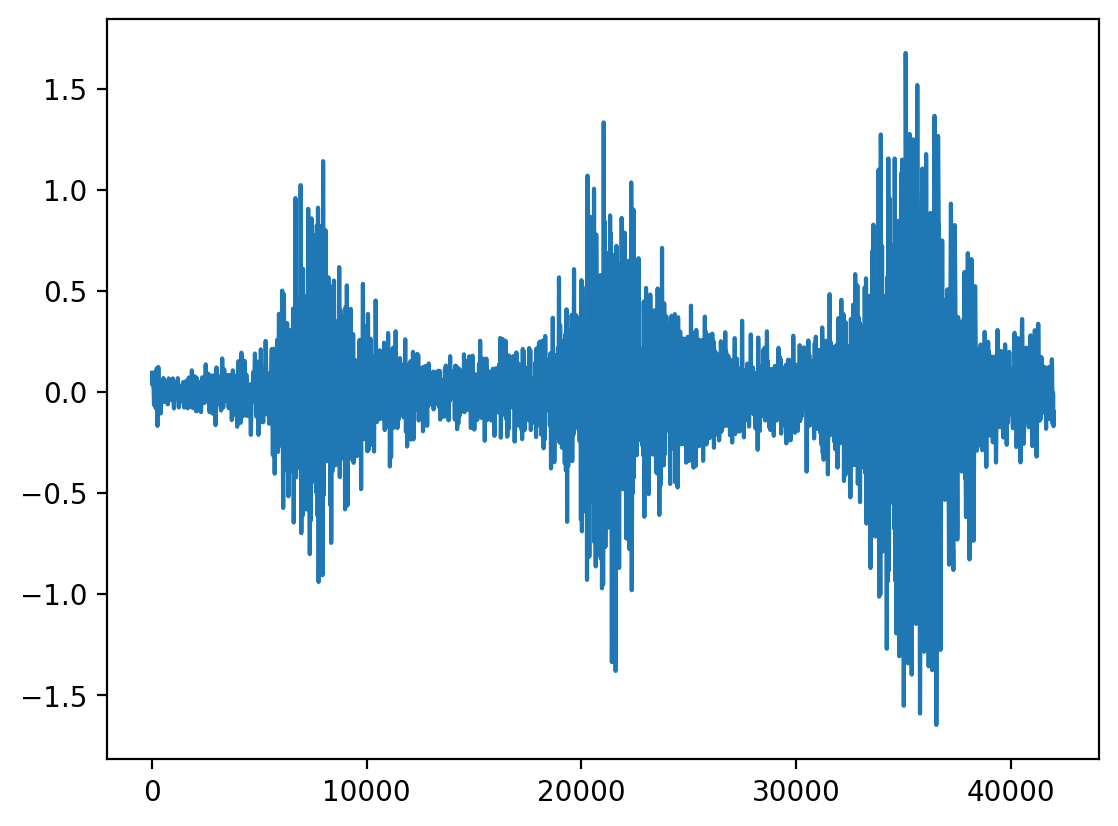

In [34]:
plt.plot(result)

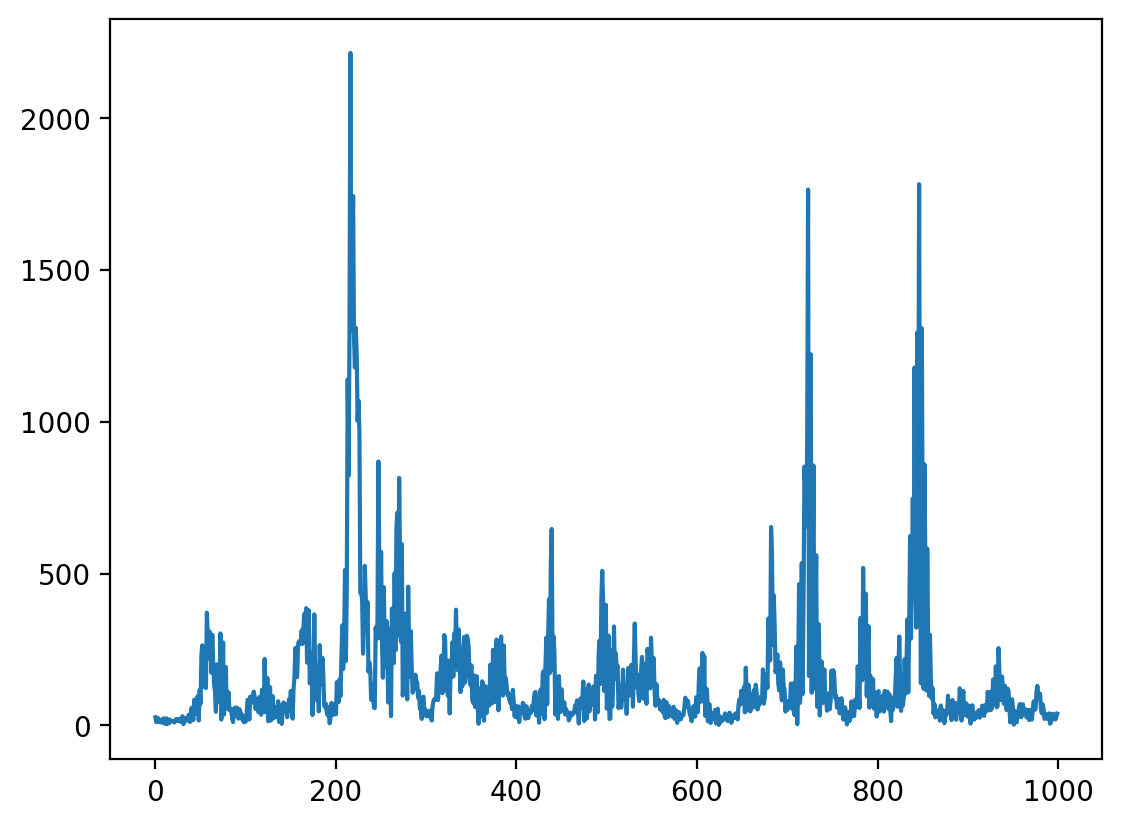

In [35]:
plt.plot(np.abs(np.fft.rfft(result))[:1000])